<a href="https://colab.research.google.com/github/imbukwa1/AI-Based-Tomato-Health-Monitoring-For-Farmers/blob/main/AI_Based_Tomato_Health_Monitoring_For_Farmers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


*   Audry Imbukwa 670682



#AI Based Tomato Health Monitoring For Farmers
Below is how we searched for the Data and the various Sources.


Here are some of the Keywords that we used in Our Data search.

For Tomato Mosaic [Mosaic, Tomato Mosaic Disease, Tomato Mosaic Leaves]


*   (Tomato leaves) AND (Mosaic Virus)
*   (Tomato Mosaic leaves) OR (Tomato Mosaic Virus)


For Tomato Septoria Datasets [Septotia, Septoria tomato disease]

For Tomato Septoria Datasets [Septotia, Septoria tomato disease]

For Tomato Blight Datasets [Blight, Tomato Blight, Tomato Blight Disease]

For Healthy  Tomato Datasets[Healthy Tomato Leaves, Healthy tomato]



Here are the Various Techniques used in Data Collections.

*   Manually
*   Scrapping using a python Sript
*   Hybrid Technique using both Manual and python scrapping tools[Selenium]


In [ ]:
# Install required packages (run this once in Colab)
!pip install -q tensorflow scikit-learn matplotlib seaborn

In [ ]:
# Core libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tqdm import tqdm

# Keras and transfer learning tools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras import regularizers

# Sklearn for evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


Our Objective here is to download the Datasets that has been stored on our GoogleDrive and stored in sample_data folder

In [ ]:
'''
    This section downloads our dataset from OneDrive for model training and validation. To verify the downloaded dataset, one can access the drive folder through: https://drive.google.com/file/d/1BgH_nCJ7rP2PQX1xpZutkmZ-EstymD1p/view?usp=sharing
    After running this section, the downloaded zip file path: /content/Tomatato.zip
'''
# One can directly access the dataset on OneDrive using the link:
!gdown --fuzzy 'https://drive.google.com/file/d/1BgH_nCJ7rP2PQX1xpZutkmZ-EstymD1p/view?usp=sharing' -O Tomato.zip # Automatically downloads zipped dataset folder in Colab

Downloading...
From (original): https://drive.google.com/uc?id=1BgH_nCJ7rP2PQX1xpZutkmZ-EstymD1p
From (redirected): https://drive.google.com/uc?id=1BgH_nCJ7rP2PQX1xpZutkmZ-EstymD1p&confirm=t&uuid=d3a06d5c-3a43-4854-bde9-0e94d9910cad
To: /content/Tomato.zip
100% 41.0M/41.0M [00:00<00:00, 54.3MB/s]


First, we are  doing a little directory cleaning. If there’s any previously extracted version of the dataset sitting in the target directory, we are wipe it clean using shutil.rmtree



Now we are  unzipping my Tomato.zip file, which contains the entire tomato disease dataset.

-q: Quiet mode   keeps the output clean.

-o: Overwrites existing files without asking.

-d: Specifies the destination directory where everything should land.

After extraction, we defined the base directory where the dataset lives and create a list of the four disease categories/classes. This will help later when we are  building the data generators or loading images for custom processing.

In [ ]:
'''
    This section unzips the folder /content/Tomato.zip and saves new folder  /content/sample_data/Tomato
'''
import shutil

shutil.rmtree('/content/sample_data/Tomato/Tomato Health', ignore_errors=True)

!unzip -qo Tomato.zip -d /content/sample_data/Tomato # Unzipping the Zipped folder downloaded from Drive.

base_dir = "/content/sample_data/Tomato/Tomato Health"

class_folders = ['blightTomatoes', 'healthyTomatoes', 'mosaicTomatoes', 'septoriaTomatoes'] # naming the four classes (Data labels)


 Check for Corrupt Images

In [ ]:
CHECK_IMAGES = True  # Verifies image integrity


if CHECK_IMAGES:
    from PIL import Image
    from tqdm import tqdm

'''
    The function checks integrity of all images, filtering the corrupted ones.
    it takes folder path parameter as input and returns a list of corrupted images.
'''
def check_images(folder_path):
        print("Verifying image integrity...")
        bad_files = []
        for label in os.listdir(folder_path):
            class_dir = os.path.join(folder_path, label)
            for file in tqdm(os.listdir(class_dir), desc=f"Checking {label}"):
                try:
                    img_path = os.path.join(class_dir, file)
                    img = Image.open(img_path)
                    img.verify()
                except Exception:
                    bad_files.append(img_path)
        print(f"Found {len(bad_files)} corrupted files.")
        return bad_files

check_images(base_dir) # function call


Verifying image integrity...


Checking blightTomatoes: 100%|██████████| 500/500 [00:00<00:00, 14304.78it/s]

Found 0 corrupted files.


[]

#Data Augmentation & Split (80/20)

we are  setting up my image input pipeline parameters:

img_size: Each image is resized to 224x224, which is the input size expected by MobileNetV2.

batch_size: We'll feed 32 images at a time into the model  for better speed and memory usage.

we are also Normalizing  pixel values (0–255 → 0–1) for faster convergence

Also splits the dataset: 80% for training, 20% for validation using validation_split=0.2.

Augments training images to boost generalization:

Random rotation (±20°)

Random zoom (up to 20%)

Horizontal flipping (like leaf mirroring)

In [ ]:
img_size = 224 # image dimensions to have images of uniform size
batch_size = 32 # Number of images the model interacts once

# Augment and normalize the data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Training percentage (80%)
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=class_folders # Class folders (labels)
)

# Validation percentage (20%)
val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=class_folders
)

Found 1508 images belonging to 4 classes.
Found 377 images belonging to 4 classes.


 #Visualizing Class Distribution in the Dataset

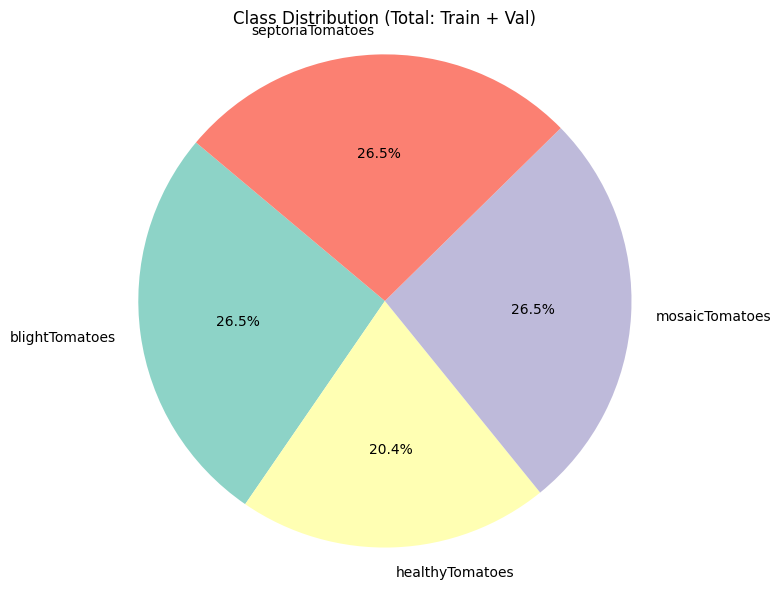

In [ ]:
import matplotlib.pyplot as plt  # Library for data visualization
import numpy as np

labels = list(train_generator.class_indices.keys())
class_counts = np.bincount(train_generator.classes)
# Combine train + val counts
val_counts = np.bincount(val_generator.classes)
total_counts = class_counts + val_counts

# Pie chart of overall dataset
plt.figure(figsize=(7, 7))
plt.pie(total_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Set3.colors)
plt.title("Class Distribution (Total: Train + Val)")
plt.axis('equal')
plt.show()


#Quick Visual Check , What’s Actually in Our Dataset Batches?

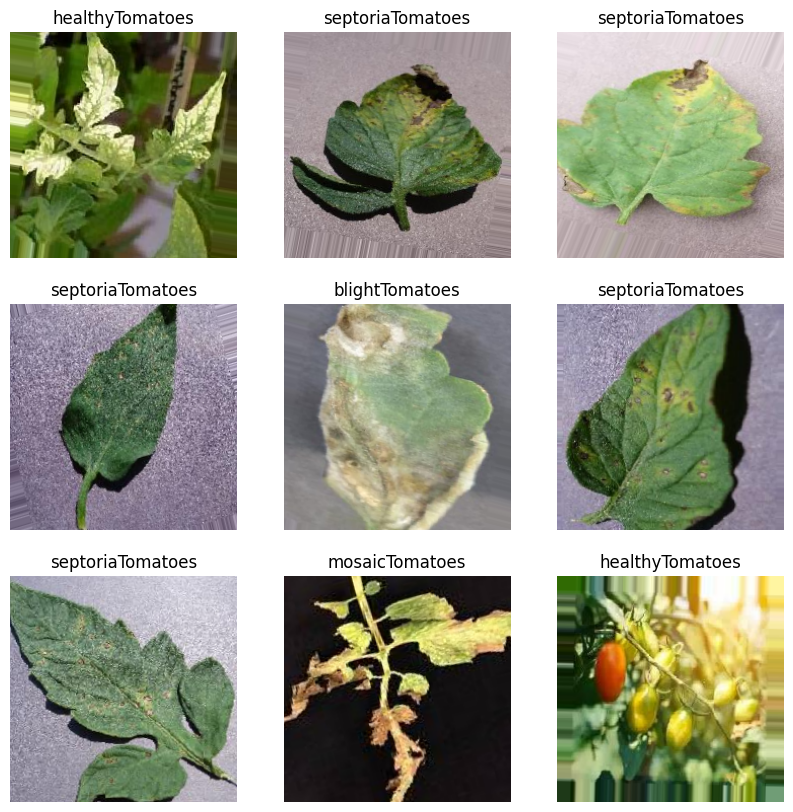

In [ ]:
# This code section displays a sample of our data set with labels (specific classes)
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(10, 10))

images, labels, *rest = next(train_generator)


for i in range(len(images)):
  if i >= 9:
    break
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow((images[i] * 255).astype("uint8")) # Rescaling each image from [0-1] back to [0-255]

  predicted_class_index = np.argmax(labels[i]) # Getting labels for each fetched image.

  predicted_class_name = class_names[predicted_class_index]
  plt.title(predicted_class_name)
  plt.axis("off")

plt.show()

 # Compute Class Weights to Handle Imbalance

In [ ]:
y_train = train_generator.classes
class_weights = dict(zip(
    np.unique(y_train),
    compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
))

print("Class Weights:", class_weights)


Class Weights: {np.int32(0): np.float64(0.9425), np.int32(1): np.float64(1.224025974025974), np.int32(2): np.float64(0.9425), np.int32(3): np.float64(0.9425)}


# Building the Tomato Classifier with Transfer Learning
Load Pretrained MobileNetV2 (Feature Extractor).
we are  using MobileNetV2 as the base of my tomato disease classifier. Why? Because it’s lightweight, fast, and trained on ImageNet, so it already knows how to detect generic visual features like edges, textures, and shapes.

trainable=False: we freeze the base model so it doesn’t get updated during training . this speeds things up and protects the pretrained features.

we start by flattening the output of the base model using global average pooling. This reduces the number of parameters and helps prevent overfitting.

In [ ]:
'''
    This code section creates the model from MobileNetV2 applying transfer learning technique, compiles and prints the model summary.
'''
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu',
          kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(x)
x = Dropout(0.6)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,435,588 (9.29 MB)

 Trainable params: 175,044 (683.77 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

# Train the Model with Checkpoints

In [ ]:
'''
    This section trains the model with 50 epochs and  four callbacks. The call backs serve the following purposes:
    (i) ModelCheckPoint : Saves the model's weights to a file whenever the val_accuracy improves, ensuring you keep the best-performing version.
    (ii)EarlyStopping: Halts training if the val_loss doesn't improve for 10 epochs, preventing overfitting and saving training time.
   (iii) ReduceLROnPlateau: Lowers the learning rate by a factor of 0.1 if the val_loss plateaus for 5 epochs, helping the model escape local minima.
   (iv) TerminateOnNaN: Stops training if the model's loss becomes "Not a Number" (NaN), which is a sign of unstable training.

'''
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
terminator = TerminateOnNaN()

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint, early_stop, reduce_lr, terminator]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.4655 - loss: 46.6906
Epoch 1: val_accuracy improved from -inf to 0.69231, saving model to best_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 46s 694ms/step - accuracy: 0.4685 - loss: 46.4902 - val_accuracy: 0.6923 - val_loss: 18.4565 - learning_rate: 0.0010
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8006 - loss: 12.9247
Epoch 2: val_accuracy improved from 0.69231 to 0.74801, saving model to best_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 464ms/step - accuracy: 0.8009 - loss: 12.8447 - val_accuracy: 0.7480 - val_loss: 3.7010 - learning_rate: 0.0010
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.8102 - loss: 2.9695
Epoch 3: val_accuracy did not improve from 0.74801
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 422ms/step - accuracy: 0.8104 - loss: 2.9649 - val_accuracy: 0.7454 - val_loss: 2.5159 - learning_rate: 0.0010
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.8287 - loss: 2.3117
Epoch 4: val_accuracy improved from 0.74801 to 0.76393, saving model to best_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 444ms/step - accuracy: 0.8284 - loss: 2.3122 - val_accuracy: 0.7639 - val_loss: 2.5304 - learning_rate: 0.0010
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.7956 - loss: 2.4736
Epoch 5: val_accuracy improved from 0.76393 to 0.77984, saving model to best_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 441ms/step - accuracy: 0.7957 - loss: 2.4760 - val_accuracy: 0.7798 - val_loss: 2.8385 - learning_rate: 0.0010
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.8004 - loss: 2.8426
Epoch 6: val_accuracy did not improve from 0.77984
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 414ms/step - accuracy: 0.8003 - loss: 2.8449 - val_accuracy: 0.7454 - val_loss: 2.8250 - learning_rate: 0.0010
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8439 - loss: 2.4230
Epoch 7: val_accuracy did not improve from 0.77984
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 436ms/step - accuracy: 0.8441 - loss: 2.4167 - val_accuracy: 0.7745 - val_loss: 1.7715 - learning_rate: 1.0000e-04
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8813 - loss: 1.4681
Epoch 8: val_accuracy improved from 0.77984 to 0.78515, saving model to best_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 442ms/step - accuracy: 0.8812 - loss: 1.4663 - val_accuracy: 0.7851 - val_loss: 1.3912 - learning_rate: 1.0000e-04
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.9026 - loss: 1.1795
Epoch 9: val_accuracy did not improve from 0.78515
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 434ms/step - accuracy: 0.9023 - loss: 1.1790 - val_accuracy: 0.7745 - val_loss: 1.2369 - learning_rate: 1.0000e-04
Epoch 10/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.8785 - loss: 1.0825
Epoch 10: val_accuracy improved from 0.78515 to 0.79045, saving model to best_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 428ms/step - accuracy: 0.8784 - loss: 1.0824 - val_accuracy: 0.7905 - val_loss: 1.1749 - learning_rate: 1.0000e-04
Epoch 11/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.8713 - loss: 1.0473
Epoch 11: val_accuracy did not improve from 0.79045
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 435ms/step - accuracy: 0.8715 - loss: 1.0470 - val_accuracy: 0.7719 - val_loss: 1.1482 - learning_rate: 1.0000e-04
Epoch 12/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.8747 - loss: 1.0098
Epoch 12: val_accuracy did not improve from 0.79045
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 434ms/step - accuracy: 0.8745 - loss: 1.0098 - val_accuracy: 0.7586 - val_loss: 1.1495 - learning_rate: 1.0000e-04
Epoch 13/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.8667 - loss: 0.9861
Epoch 13: val_accuracy did not improve from 0.79045
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - accuracy: 0.8667 - loss: 0.9864 - val_accuracy: 0.7878 - val_loss: 1.1206 - learning_rate: 1.0000e-04

48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 422ms/step - accuracy: 0.8776 - loss: 0.8080 - val_accuracy: 0.7958 - val_loss: 0.9529 - learning_rate: 1.0000e-05


# Training Performance Visualization

This block plots how the model performed across training epochs  visually tracking accuracy and loss for both training and validation sets.

Left Plot:
Shows how well the model learned (accuracy).
Helps identify overfitting if training accuracy climbs while validation plateaus or drops.

Right Plot:
Tracks how efficiently the model minimized error (loss).
A diverging train/val loss pattern is a red flag for overfitting.

Why It Matters:
Gives instant visual feedback on model learning behavior.

Helps determine if training was cut off too early, too late, or just right.

Makes debugging performance issues (like underfitting or overfitting) much easier.

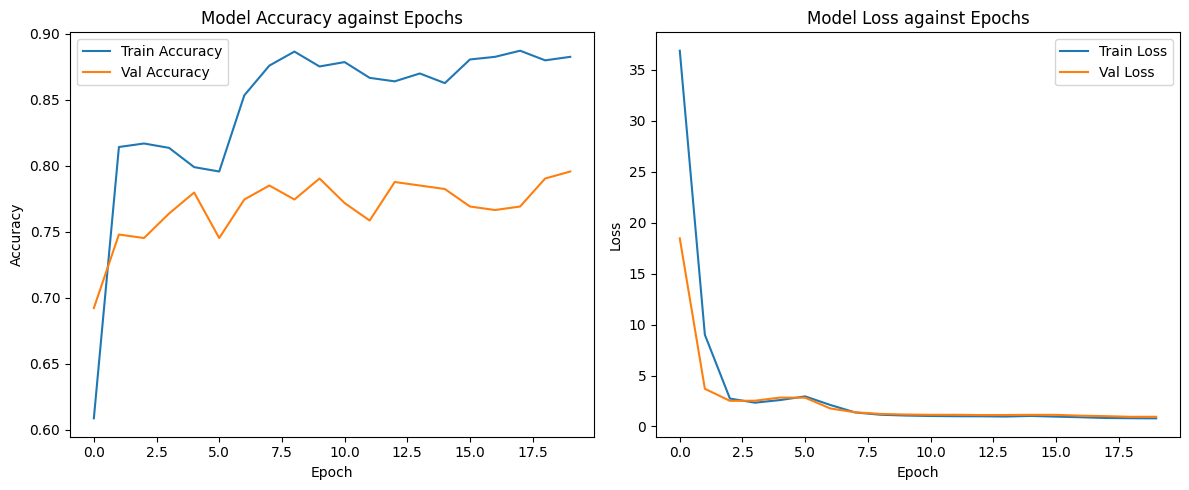

In [ ]:
'''
    This code section visulizes the training and validation performance of the model by creating graphs of Model accuracy against Epochs and Model Loss against Epochs.
'''
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy against Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss against Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Model Evaluation on Validation Set.

This block gives us  a clear, quantifiable look at how our model performs on real-world data  beyond just accuracy. It's crucial for debugging performance and validating if the model is ready for deployment.

12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 645ms/step
Classification Report:

                  precision    recall  f1-score   support

  blightTomatoes       0.79      0.79      0.79       100
 healthyTomatoes       0.74      0.64      0.69        77
  mosaicTomatoes       0.72      0.66      0.69       100
septoriaTomatoes       0.81      0.96      0.88       100

        accuracy                           0.77       377
       macro avg       0.76      0.76      0.76       377
    weighted avg       0.77      0.77      0.76       377



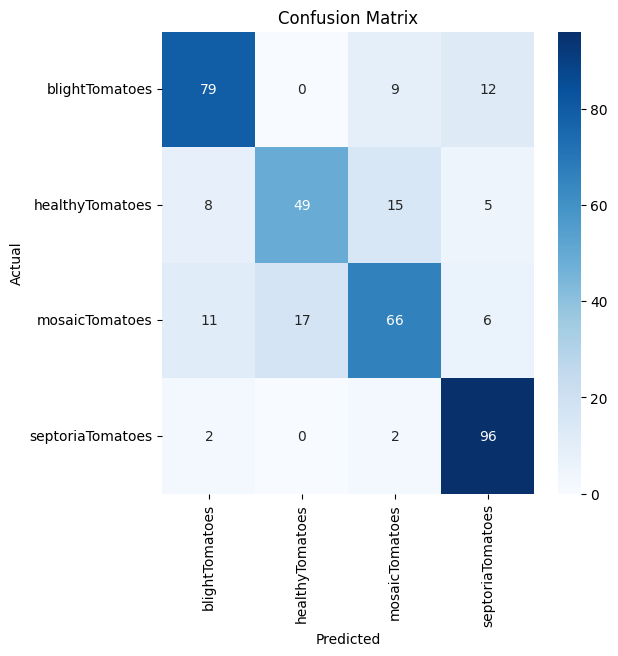

In [ ]:
'''
    This evaluates model performance using metrics such as accuracy, precision, f1, recall and visualize the performance by confusion matrix graph.
'''
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

val_generator.reset()
predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = val_generator.classes

# Get actual classes present in y_true
unique_classes = np.unique(y_true)
class_labels = [k for k, v in val_generator.class_indices.items() if v in unique_classes]

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Saving portable version of the trained model

In [ ]:
'''
    This code section saves the trained model to a file named 'tomato_disease_model_final.h5' so that it can be used later for deployment and integration in an app without retraining it.
'''
model.save('/content/sample_data/tomato_disease_model_final.h5')
print("Model saved!")


Model saved!


# Deploying the working prototype with Gradio

In [ ]:
!pip install gradio --quiet
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

# Load trained model
model = tf.keras.models.load_model('/content/sample_data/tomato_disease_model_final.h5')

# Define class labels
class_names = ['blightTomatoes', 'healthyTomatoes', 'mosaicTomatoes', 'saptoriaTomatoes']

def predict_image(img):
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = img_array[np.newaxis, ...]

    preds = model.predict(img_array)
    pred_label = class_names[np.argmax(preds)]
    confidence = np.max(preds)

    return {label: float(prob) for label, prob in zip(class_names, preds[0])}


In [ ]:
gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=4),
    title=" Tomato Disease Classifier",
    description="Upload an image of a tomato leaf to detect if it's healthy or has mosaic, blight, or septoria."
).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ea299add9813625633.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
